<a href="https://colab.research.google.com/github/PabloMendieta03/AprendizajeAutomatico-/blob/main/AlgoritmoGenetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 4**

 Grupo 1: Carmen Gallardo, Marta Herraiz y Pablo Mendieta


En esta práctica se va a utilizar el algoritmo genético para encontrar máximos o mínimos en una serie de funciones.

 Primero vamos a instalar todas las librerías necesarias para el algoritmo genético y definimos la función que se va a utilizar para mostar los resultados gráficamente.

In [ ]:
!pip install deap
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scoop

import random
import math
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random

def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    # Información sobre el número de generaciones
    gen = log.select("gen")
    # Mínimos, máximos y media de la función de aptitud en cada generación
    fit_mins = np.array(log.select("min"))
    fit_maxs = np.array(log.select("max"))
    fit_ave = np.array(log.select("avg"))

    # Asegurar que todas las listas tengan la misma longitud
    min_len = min(len(gen), len(fit_mins), len(fit_maxs), len(fit_ave))
    gen = gen[:min_len]
    fit_mins = fit_mins[:min_len]
    fit_maxs = fit_maxs[:min_len]
    fit_ave = fit_ave[:min_len]

    # Representación de los valores anteriores
    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.fill_between(gen, fit_mins, fit_maxs, where=fit_maxs >= fit_mins, facecolor='g', alpha=0.2)

    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi=300)

# **EJERCICIO 1**

Encontrar los máximos de la función :

$ z = f(x,y) = 3(1-x^2)e^{-(x^2) - (y+1)^2} - 10(x/5 - x^3 - y^5)e^{-x^2 - y^2} - 1/3e^{-(x+1)^2 - y^2} $


en el dominio :

  $ (x, y) \in [-100, 100]  $

## Representación gráfica

Se define la función objetivo funcion_objetivo que toma un individuo (representado como una pareja de coordenadas x e y) y devuelve el valor de la función evaluada en ese punto.

In [ ]:
# Definimos la función objetivo
def funcion_objetivo(ind):
    x, y = ind
    res = 3 * (1 - x)**2 * np.exp(-(x**2) - (y + 1)**2) - 10 * (x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x + 1)**2 - y**2)
    return res,

Se establece una semilla aleatoria para que los números pseudoaleatorios generados por NumPy sean consistentes en diferentes ejecuciones del código.

In [ ]:
np.random.seed(0)

Se generan vectores x e y que cubren todo el dominio de la función objetivo, dividiendo el rango de -100 a 100 en 1000 puntos. Despúes, se crea una cuadrícula bidimensional (meshgrid) usando los vectores x e y, y se evalúa la función objetivo en cada par de coordenadas. Los resultados se almacenan en una matriz bidimensional fx.

In [ ]:
x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)
# Evaluamos todos los valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([funcion_objetivo(val) for val in vals],(1000, 1000))

Text(0.5, 0, 'f(x,y)')

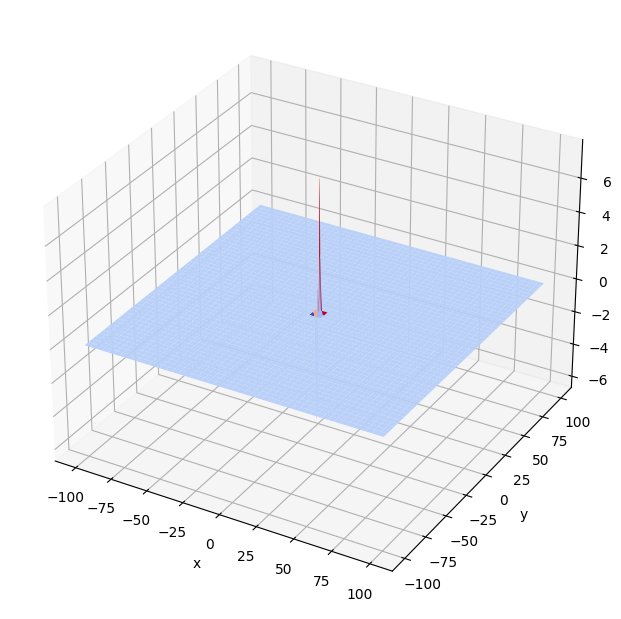

In [ ]:
# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
# ax = figure_3d.gca(projection="3d")
ax = figure_3d.add_axes(Axes3D(figure_3d))
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")

Analizando gráficamente la función, observamos que el intervalo de [-100, 100] es demasiado grande y existen demasiados valores innecesarios. Por ello, vamos a acotarla entre [-5. 5] para eliminar dicho problema.

Text(0.5, 0, 'f(x,y)')

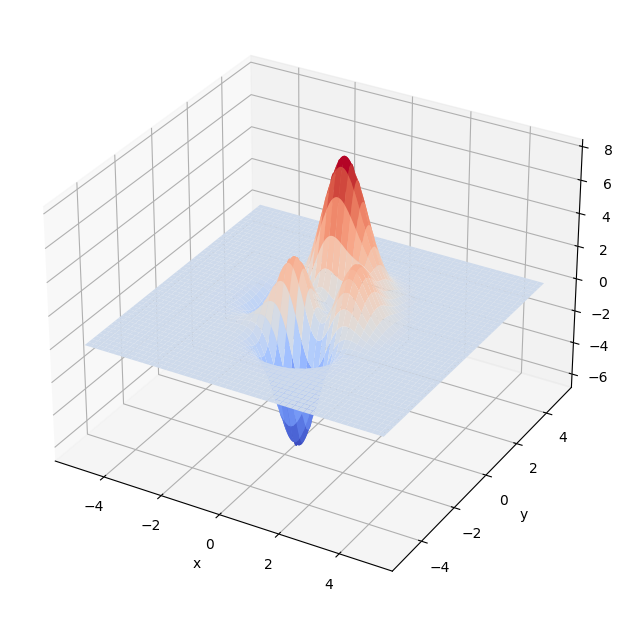

In [ ]:
# Generamos vectores nuevos
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)

# Evaluamos todos los nuevos valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([funcion_objetivo(val) for val in vals],(1000, 1000))

# Mostramos el resultado
figure_3d = plt.figure(figsize=(8,6))
ax = figure_3d.add_axes(Axes3D(figure_3d))
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")


Ahora podemos ver mucho mejor como se comporta la función y se aprecia claramente un máximo que está próximo al 8.

## Algoritmo genético

Este bloque de código se enfoca en la configuración de las herramientas y objetos necesarios para definir el problema y los individuos en el contexto de un algoritmo genético.
FitnessMax representa la función de aptitud que se desea maximizar (en este caso, maximizar la función objetivo), y Individual representa un individuo en la población, que tendrá una lista de genes y un atributo de aptitud.
Se crea una caja de herramientas (toolbox) donde registraremos todas las funciones del algoritmo genético.
Se registra una función llamada "attr_uniform" en la caja de herramientas, que utilizará la función random.uniform para generar valores uniformemente distribuidos entre -5 y 5. Este será el generador de genes para los individuos.

In [ ]:
# Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

toolbox.register("attr_uniform", random.uniform, -5, 5)
# Probamos y vemos que generamos un número leatorio entre -5y 5 distinto cada vez
toolbox.attr_uniform()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2.493885927636267

Posteriormente, pasamos a la generación de los invididuos de la población. Es relevante mencionar que los individuos están formados por dos dimensiones ( Cada individuo tendrá dos genes, ya que la función "attr_uniform" se repetirá dos veces), como podemos ver en el ejemplo.

In [ ]:
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, 2)
# Ejemplo de la generación de un individuo aleatorio
individuo = toolbox.individual()
individuo


[-0.6094850664644333, -0.7990782670548402]

**Definimos el tamaño de la población**

La población tendrá 128 individuos, ya que se necesitan 64 bits para la representación de la solución. Nos basamos en la fórmula de: tamaño población está entre [l, 2l], en nuestro caso entre [128, 256]. La longitud de los individuos (l) es 128 ya que tenemos dos dimensiones (64x2).

In [ ]:
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, 128)
#Ejemplo de creación de una población. Se ve que es una lista de 128 listas (una por cada individuo)
poblacion = toolbox.population()
print(poblacion)
len(poblacion)

[[3.649724460784089, -3.848846674003962], [-3.4772496942435582, -1.379967127768941], [4.501662002472269, -0.6389051613111612], [2.2290166180499673, 0.4182649153726885], [-2.7621407185041305, 1.775978812923901], [-3.2989802363244616, 1.798451382282166], [-4.700851800165326, -2.7866401937187235], [1.226027650810031, 4.590549141638492], [4.718111994698628, 2.000615922115375], [-2.5786159260848427, 3.8570988431452857], [3.5560691452079602, 2.3685189542159932], [-1.8773355971727734, 1.2187464824660585], [-2.7441291660212217, -4.929978543366563], [1.627481723360484, 1.9489960549214], [-4.6448185225628125, 4.160228383289873], [-1.5772602429687566, -1.6852506513538157], [4.430978984819374, 1.3206163117454874], [3.2645473943458576, 3.7874366143213916], [-1.1893109083029199, -3.9590112261333985], [-0.5550495417976942, 2.003405768784411], [-0.6397875619634554, 2.457085062620843], [4.588860316968349, 0.7755062004740241], [-4.929826809463812, -3.9321970932229555], [-3.0126787918497455, 4.8245409487

128

Añadimos el resto de funciones necesarias para el algoritmo genético. La función evaluate sirve como función de aptitud y calcula la aptitud de cada invididuo. La función mate es el apareamiento (con 1 punto de cruce). La función mutate se utiliza para calcular las mutaciones de los invidivuos. Se basa en una distribución gaussiana.
La seleción se realiza mediante la función select, que utiliza el método del torneo.

In [ ]:
# Registro de operaciones genéticas
toolbox.register("evaluate", funcion_objetivo)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


 **Alogritmo Genético**

Esta función main es la engargada de realizar el algoritmo genético con las herramientas definidas anteriormente. Vamos a utilizar los siguientes parámetros:

*   Probabilidad de Cruce = 0.5
*   Probabilidad de Mutación = 0.2
*   Número de Generaciones = 35

Vamos a hacer uso del Algoritmo eaSimple que nos devuelve el resultado final así como su evolución a lo largo de las generaciones.



In [ ]:
def mainF1():

    # Definimos la semilla del generador de números aleatorios para tener resultados fijos
    random.seed(8)

    CXPB, MUTPB, NGEN = 0.7, 0.2, 35

    # Generamos la Población Inicial
    pop = toolbox.population()

    # Definimos el objeto hof que almacenará el mejor individuo
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Registramos en el objeto stats las funciones estadísticas a usar
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    # Algoritmo eaSimple, devuelve la población final y el registro de evolución
    # y tiene como entrada:
    # population – población inicial
    # toolbox – La caja de herramientas con todas las funciones necesarias
    # cxpb – Probabilidad de cruce en tanto por uno
    # mutpb – Probabilidad de mutación en tanto por uno
    # ngen – Nº de generaciones del algoritmo
    # stats – Objeto estadístico con las funciones registradas (opcional)
    # halloffame – Objeto del tipo HallOfFame con los mejores individuos por generación, opcional
    # verbose – Si se deben mostrar o no las estadísticas de cada generación
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)

    # Devolvemos el HallOfFame y el registro de evolución
    return hof, logbook

In [ ]:
best1, log1 = mainF1()
print("Mejor fitness: %f" %best1[0].fitness.values)
print("Mejor individuo %s" %best1[0])

gen	nevals	avg     	std    	min     	max    
0  	128   	0.296062	1.15633	-2.18389	7.98912
1  	90    	0.400195	2.04931	-4.61996	8.02036
2  	96    	1.18636 	2.10764	-5.92524	8.02036
3  	103   	2.54039 	2.53987	-6.26467	8.03942
4  	95    	4.48482 	2.49539	-0.564622	8.03942
5  	94    	6.13128 	2.21975	-4.87251 	8.03942
6  	104   	7.17348 	1.9849 	-0.00204996	8.05815
7  	93    	7.79791 	1.20414	-6.62676e-31	8.06748
8  	98    	7.57201 	1.91653	-4.23868    	8.06748
9  	98    	7.73994 	1.55781	-0.000492491	8.06748
10 	98    	7.79981 	1.49387	-2.67064    	8.06748
11 	107   	7.92301 	1.01921	1.63567e-40 	8.06748
12 	93    	7.955   	0.899358	7.78922e-06 	8.06748
13 	104   	7.74326 	1.53431 	1.95602e-61 	8.06748
14 	93    	7.82157 	1.3705  	-6.85795e-06	8.06748
15 	104   	7.71348 	1.7794  	-5.64499    	8.06748
16 	109   	7.79056 	1.56086 	-3.17575    	8.06748
17 	96    	7.82361 	1.36087 	-0.0985054  	8.06748
18 	103   	7.88589 	1.17421 	-1.58497e-06	8.06748
19 	109   	7.81533 	1.39469 	-2.4353e-23

Podemos ver que el algoritmo alcanza un fitness muy similar a el que observamos en la gráfica.

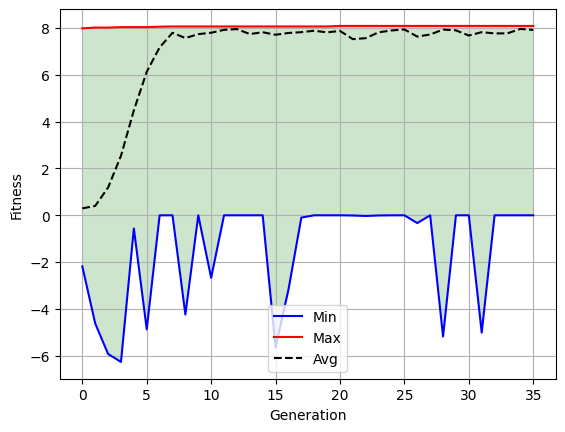

In [ ]:
plot_evolucion(log1)

Según la gráfica que se ha mostrado, podemos ver que se llega muy rápido al máximo, es prácticamente una recta, se representa con la línea roja. Esto indica que el algortimo converge muy rápido(Explotación). Por otro lado la media, converge rápido también hacia el máximo, pero no es igual de rápida que el máximo. Esta representa mejor como mejora el algoritmo, va expotando los máximos que interesan, mientras siga habiendo mínimos.

En cuanto al mínimo, podemos ver que existen picos. Esto se podría explicar gracias a la exploración, ya que el algoritmo trata de buscar nuevas opciones, porque aunque ya haya alcanzado un máximo puede que sea local, por lo que nuevos individuos puedes acercarnos más a otras soluciones posibles.

La zona verde representa la cantidad de exploración que se está dando durante el algoritmo. Esta exploración la vamos a explicar más profundamente más adelante, cuando usamos dos puntos de cruce en vez de uno.

#**EJERICIO 2:**
Dada la función de Rastring con A = 10 y x_i perteneciente a (-5.12, 5.12).
Implementarla y minimizarla para n = 10:












## Representación gráfica

Realizamos la representación gráfica de la misma manera que el ejercicio anterior, pero esta vez con la nueva función.

In [ ]:
# Definimos la función para A = 10
def rastrigin_function(individual):
    A = 10
    n = len(individual)
    return A * n + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in individual]),


Text(0.5, 0, 'f(x,y)')

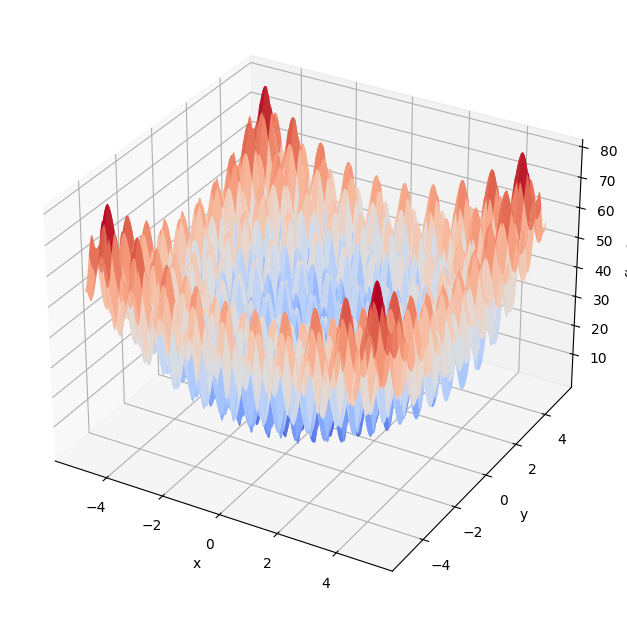

In [ ]:
# Generamos vectores que barran todo el dominio
x = np.linspace(-5.12, 5.12, 1000)
y = np.linspace(-5.12, 5.12, 1000)

# Evaluamos todos los valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([rastrigin_function(val) for val in vals],(1000, 1000))

# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
# ax = figure_3d.gca(projection="3d")
ax = figure_3d.add_axes(Axes3D(figure_3d))
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")


Ahora ya tenemos una idea general de como es la función. Se puede ver que existen muchos mínimos locales donde el algoritmo podría tener problemas y el mínimo absoluto se encuentra en el valor 0.

## Algortimo genético

Vamos a realizar el mismo proceso que en el Ejercicio 1 para crear el algoritmo genético, pero esta vez los individuos van a ser de 10 dimensiones. Esto hará que varíe el tamaño de la población inicial ya que el genotipo de los individuos va a ser de mucho más tamaño. Como se puede ver en el individuo de ejemplo, esta formado por 10 dimensiones.

In [ ]:
 # Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox2 = base.Toolbox()

# Generación de genes en el rango deseado
toolbox2.register("attr_float", random.uniform, -5.12, 5.12)
# Probamos y vemos que generamos un número leatorio entre -5.12 y 5.12 distinto cada vez
toolbox2.attr_float()
# Generación de inviduos y población
# Cada individuo tendrá 10 genes, para ello, la función "attr_float" se repetirá diez veces
# Esto se debe a que estamos trabajando en 10D. Luego, necesitamos 10 variables y n = 10
toolbox2.register("individual", tools.initRepeat, creator.Individual,
                 toolbox2.attr_float, n = 10)

# Ejemplo de la generación de un individuo aleatorio
individuo = toolbox2.individual()
individuo

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[-3.3776534412089565,
 0.7544123686679596,
 2.0778413810387715,
 0.7195625145056797,
 3.7629592894726818,
 1.2474593226962067,
 -2.5077648075956995,
 3.374655209463568,
 5.0586631203914605,
 4.86363061516711]

**Definimos el tamaño de la población:**

Comenzamos probando con una población de 640 individuos, ya que al igual que antes, nos basamos en [l, 2l]. Para la solución de este problema hacen falta 64 bits * 10 (trabajamos en 10D), luego podemos usar una población entre 640 y 1280 individuos.
Esto es porque, como hemos comentado antes, cada individuo tendrá 10 genes, luego se multiplica por 10.



In [ ]:
# Comenzamos probando con una población de 640 individuos, aunque se puede aumentar
# o disminuir para mejorar el rendimiento de la función
toolbox2.register("population", tools.initRepeat, list,
                 toolbox2.individual, 640)


Registramos las mismas operaciones geneticas que en el caso anterior:

In [ ]:

# Calcula el valor de aptitud de un individuo.
toolbox2.register("evaluate", rastrigin_function)
# Apareamiento = mate, realiza un cruce de un punto entre dos individuos
toolbox2.register("mate", tools.cxOnePoint)
# Añade un valor de una distribución gaussiana a cada gen del individuo, guarda la media, la desviación y la probabilidad de mutación
toolbox2.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 3, indpb=0.1)
# Varios individuos compiten entre sí y se selecciona el mejor de ellos. El parámetro 'tournsize' controla el tamaño del torneo
toolbox2.register("select", tools.selTournament, tournsize=5)


Realizamos la función del algoritmo genético de la misma manera, solo que en este caso vamos a modificar la probabilidad de  mutación. Vamos a aumentarla ya que como hemos comentado antes en este ejercicio existen muchos mínimos locales por lo que nos interesa tener exploración (la mutación aporta exploración).

In [ ]:
def mainF2():
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    random.seed(30)

    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    # Los valores son de prueba para obtener unos resultados preeliminares
    CXPB, MUTPB, NGEN = 0.7, 0.3, 70
    #Generamos la Población Inicial
    pop = toolbox2.population()

    # Definimos el objeto hof que almacenará el mejor individuo
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Registramos en el objeto stats
    # las funciones estadísticas a usar
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    # Algoritmo eaSimple, devuelve la población final y el registro de evolución
    # y tiene como entrada:
    # population – población inicial
    # toolbox – La caja de herramientas con todas las funciones necesarias
    # cxpb – Probabilidad de cruce en tanto por uno
    # mutpb – Probabilidad de mutación en tanto por uno
    # ngen – Nº de generaciones del algoritmo
    # stats – Objeto estadístico con las funciones registradas (opcional)
    # halloffame – Objeto del tipo HallOfFame con los mejores individuos por generación, opcional
    # verbose – Si se deben mostrar o no las estadísticas de cada generación
    generacion_actual = 0
    max_generaciones = 100
    num_generaciones_convergencia = 0
    tolerancia_convergencia = 1e6
    poblacion_anterior = None
    diferencia_mejor_fitness = 0

    pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=CXPB,
                                        mutpb=MUTPB, ngen=NGEN, stats=stats,
                                        halloffame=hof, verbose=True)

    # Devolvemos el HallOfFame y el registro de evolución
    return hof, logbook


In [ ]:
best2, log2= mainF2()
print("Mejor fitness: %f" %best2[0].fitness.values)
print("Mejor individuo %s" %best2[0])

gen	nevals	avg    	std    	min    	max   
0  	640   	184.051	33.0483	92.3763	281.18
1  	501   	149.094	27.1882	88.7934	246.93
2  	527   	121.913	22.6091	60.4923	240.226
3  	511   	102.033	21.5118	52.2914	237.236
4  	519   	83.498 	18.5703	41.425 	187.791
5  	520   	69.9364	19.7154	33.2341	203.43 
6  	512   	56.7225	17.7356	26.0015	204.835
7  	505   	48.9526	17.6739	24.385 	185.539
8  	512   	42.4182	16.8589	20.0357	140.356
9  	511   	35.5216	15.2873	13.1694	146.32 
10 	524   	29.434 	12.9707	12.5914	120.748
11 	504   	26.2687	15.6879	10.4945	162.01 
12 	495   	23.0087	16.348 	8.16864	152.384
13 	518   	19.1543	14.3729	8.01891	128.146
14 	515   	17.1023	15.1137	6.94193	108.073
15 	518   	16.0678	16.4178	6.19677	149.828
16 	513   	13.2502	12.6928	6.19677	102.985
17 	514   	13.9667	15.9647	5.77295	140.644
18 	520   	11.4037	13.3521	5.25736	155.88 
19 	512   	11.2885	13.3191	5.25736	106.239
20 	535   	11.941 	15.4664	4.27017	114.009
21 	482   	11.2099	15.3204	4.27017	126.324
22 	517   	11.

Concluimos que el mínimo de la función se encuentra próximo al 0.

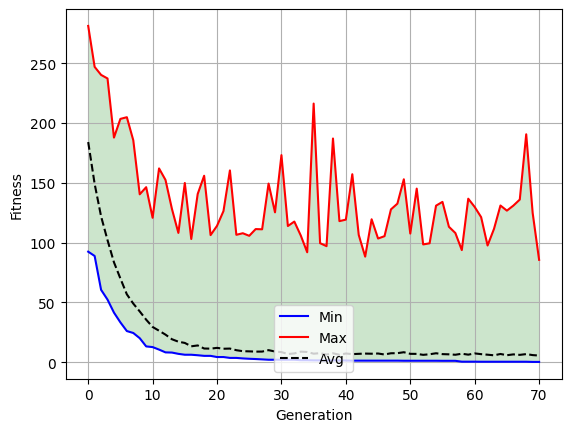

In [ ]:
plot_evolucion(log2)

Según la nueva gráfica presentada, observamos un comportamiento diferente en comparación con la anterior, ya que ahora el algoritmo genético se centra en minimizar la función en lugar de maximizarla.

En la gráfica, notamos que la curva que representa la convergencia hacia el mínimo se desplaza de manera gradual hacia el valor cero. Este comportamiento sugiere que el algoritmo está convergiendo de manera eficiente hacia la solución óptima.

A diferencia de la convergencia hacia el mínimo, los máximos muestran picos en su comportamiento. Estos picos pueden explicarse por la naturaleza exploratoria del algoritmo genético.

#DOS PUNTOS DE CRUCE

**Probamos con dos puntos de cruce en cada ejercicio**

Para ello debemos cambiar la función de cruce entre dos individuos. En vez de utilizar cxOnePoint pasamos a utilizar cxTwoPoint.

toolbox12.register("mate", tools.cxTwoPoint)

El resto de parametros se mantienen igual.


**Ejercicio 1:**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max    
0  	128   	0.296062	1.15633	-2.18389	7.98912
1  	92    	0.573478	2.03032	-5.65176	8.02036
2  	104   	1.32919 	2.58322	-3.87435	8.08533
3  	99    	2.40817 	2.66533	-3.84413	8.08533
4  	91    	4.44061 	2.62204	-0.387484	8.08533
5  	106   	6.08257 	2.24895	-3.09037 	8.09243
6  	104   	7.22672 	2.02502	-5.9058  	8.09243
7  	102   	7.75979 	1.47724	-3.93819 	8.09243
8  	86    	7.87638 	1.21446	1.81339e-34	8.09243
9  	97    	7.85171 	1.29541	1.29168e-13	8.09243
10 	101   	7.69189 	1.71659	-0.000114054	8.09243
11 	102   	7.68107 	1.80771	-2.22785    	8.09243
12 	96    	7.79582 	1.4445 	-0.137216   	8.09243
13 	99    	7.69486 	1.71699	-1.12401e-05	8.09429
14 	99    	7.72068 	1.67794	-3.99182e-06	8.09429
15 	96    	7.84415 	1.384  	2.0057e-06  	8.09429
16 	83    	7.78708 	1.52008	1.88767e-19 	8.09429
17 	106   	7.82167 	1.52539	-2.42736    	8.09429
18 	98    	7.71983 	1.70867	-1.79491    	8.09429
19 	91    	7.57426 	1.93642	-1.99403e-09	8.09429
20 	9

26 	96    	7.76355 	1.7537 	-5.83957     	8.09429
27 	96    	7.73991 	1.60408	-0.000619415 	8.09429
28 	94    	7.91883 	1.13814	2.52813e-07  	8.09429
29 	100   	7.58401 	1.87807	-0.00927627  	8.09429
30 	93    	7.90459 	1.22451	-0.000413703 	8.09429
Mejor fitness: 8.094291
Mejor individuo [-0.012571772511271905, 1.608431716118325]


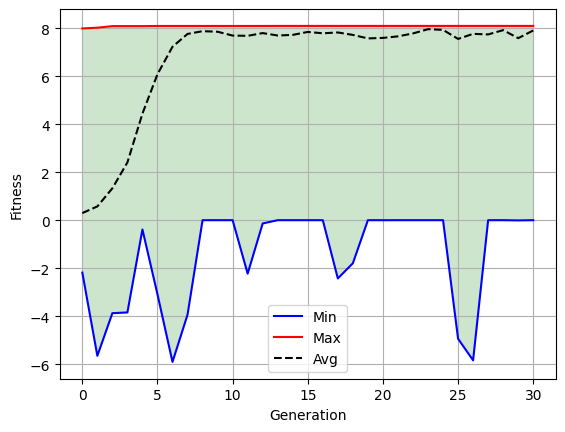

In [ ]:

# Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox12 = base.Toolbox()

toolbox12.register("attr_uniform", random.uniform, -5, 5)

# Generación de inviduos y población
toolbox12.register("individual", tools.initRepeat, creator.Individual,
                 toolbox12.attr_uniform, 2)
toolbox12.register("population", tools.initRepeat, list,
                 toolbox12.individual, 128)

# Registro de operaciones genéticas
# Calcula el valor de aptitud de un individuo.
toolbox12.register("evaluate", funcion_objetivo)
# Apareamiento = mate, realiza un cruce de un punto entre dos individuos
toolbox12.register("mate", tools.cxTwoPoint)
# Añade un valor de una distribución gaussiana a cada gen del individuo, guarda la media, la desviación y la probabilidad de mutación
toolbox12.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
# Varios individuos compiten entre sí y se selecciona el mejor de ellos. El parámetro 'tournsize' controla el tamaño del torneo
toolbox12.register("select", tools.selTournament, tournsize=3)

def mainF12():

    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    random.seed(8)

    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones

    # Los valores son de prueba para obtener unos resultados preeliminares
    CXPB, MUTPB, NGEN = 0.7, 0.2, 30

    # Generamos la Población Inicial
    pop = toolbox12.population()

    # Definimos el objeto hof que almacenará el mejor individuo
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(12)

    # Definimos un objeto para generar las estadísticas de la
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Registramos en el objeto stats las funciones estadísticas a usar
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    # Algoritmo eaSimple, devuelve la población final y el registro de evolución
    # y tiene como entrada:
    # population – población inicial
    # toolbox – La caja de herramientas con todas las funciones necesarias
    # cxpb – Probabilidad de cruce en tanto por uno
    # mutpb – Probabilidad de mutación en tanto por uno
    # ngen – Nº de generaciones del algoritmo
    # stats – Objeto estadístico con las funciones registradas (opcional)
    # halloffame – Objeto del tipo HallOfFame con los mejores individuos por generación, opcional
    # verbose – Si se deben mostrar o no las estadísticas de cada generación
    pop, logbook = algorithms.eaSimple(pop, toolbox12, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)

    # Devolvemos el HallOfFame y el registro de evolución
    return hof, logbook


best12, log12 = mainF12()
print("Mejor fitness: %f" %best12[0].fitness.values)
print("Mejor individuo %s" %best12[0])


plot_evolucion(log12)


**Ejercicio 2:**



/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std    	min    	max   
0  	640   	184.051	33.0483	92.3763	281.18
1  	492   	149.654	27.3818	55.6601	271.193
2  	487   	123.35 	24.3583	28.0557	272.975
3  	489   	101.078	22.9373	27.1832	193.952
4  	497   	80.9689	21.3929	23.6901	184.674
5  	487   	63.721 	20.3578	21.2869	195.752
6  	514   	47.3828	17.7405	17.6278	172.98 
7  	504   	37.3864	17.3477	16.1152	179.406
8  	528   	30.425 	14.9184	12.0249	118.943
9  	511   	24.5045	12.5247	8.47043	119.088
10 	512   	22.2191	14.3027	8.47043	132.334
11 	514   	19.3194	14.2451	8.47043	130.264
12 	504   	17.2433	14.4425	7.64728	124.598
13 	493   	17.5341	17.9253	7.30304	146.681
14 	515   	14.8605	14.967 	6.19233	131.955
15 	511   	13.8112	15.0905	6.19233	136.077
16 	529   	13.0136	15.1471	6.05796	140.118
17 	513   	12.3404	15.019 	5.41215	102.682
18 	523   	10.9822	13.0636	5.05355	125.26 
19 	528   	10.9064	13.6011	4.95087	117.33 
20 	522   	11.6524	14.6456	4.14996	108.956
21 	508   	11.4702	17.2252	4.01619	144.199
22 	505   	10

70 	526   	5.50597	13.788 	0.356764	88.7436
Mejor fitness: 0.356764
Mejor individuo [0.0019335283224979141, -0.001155101102889411, -0.03409480279326309, 0.006469357857068644, -0.0103649401286081, 0.0013473018326151435, -0.0011426265819177474, 0.002969176863713433, 0.011155752988194058, -0.01870801524555843]


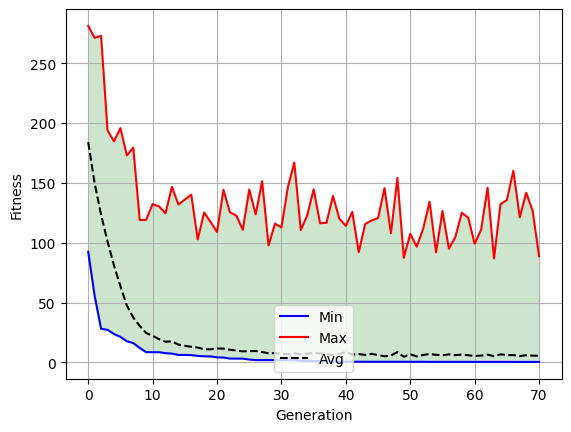

In [ ]:
 # Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox22 = base.Toolbox()

# Generación de genes en el rango deseado
toolbox22.register("attr_float", random.uniform, -5.12, 5.12)


# Generación de inviduos y población
toolbox22.register("individual", tools.initRepeat, creator.Individual,
                 toolbox22.attr_float, n = 10)

# Ejemplo de la generación de un individuo aleatorio
individuo = toolbox22.individual()
individuo

# Comenzamos probando con una población de 640 individuos, aunque se puede aumentar
# o disminuir para mejorar el rendimiento de la función
toolbox22.register("population", tools.initRepeat, list,
                 toolbox22.individual, 640)

# Recordar que individuo es una lista que tiene un atributo fitness
# donde se almacena la calidad del mismo, que al principio será
# vacío, porque aun no ha sido evaluado
individuo.fitness.values

# Registro de operaciones genéticas
# Calcula el valor de aptitud de un individuo.
toolbox22.register("evaluate", rastrigin_function)
# Apareamiento = mate, realiza un cruce de un punto entre dos individuos
toolbox22.register("mate", tools.cxTwoPoint)
# Añade un valor de una distribución gaussiana a cada gen del individuo, guarda la media, la desviación y la probabilidad de mutación
toolbox22.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 3, indpb=0.1)
# Varios individuos compiten entre sí y se selecciona el mejor de ellos. El parámetro 'tournsize' controla el tamaño del torneo
toolbox22.register("select", tools.selTournament, tournsize=5)

def mainF22():
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    random.seed(30)

    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    # Los valores son de prueba para obtener unos resultados preeliminares
    CXPB, MUTPB, NGEN = 0.7, 0.3, 70
    #Generamos la Población Inicial
    pop = toolbox22.population()

    # Definimos el objeto hof que almacenará el mejor individuo
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Registramos en el objeto stats
    # las funciones estadísticas a usar
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    # Algoritmo eaSimple, devuelve la población final y el registro de evolución
    # y tiene como entrada:
    # population – población inicial
    # toolbox – La caja de herramientas con todas las funciones necesarias
    # cxpb – Probabilidad de cruce en tanto por uno
    # mutpb – Probabilidad de mutación en tanto por uno
    # ngen – Nº de generaciones del algoritmo
    # stats – Objeto estadístico con las funciones registradas (opcional)
    # halloffame – Objeto del tipo HallOfFame con los mejores individuos por generación, opcional
    # verbose – Si se deben mostrar o no las estadísticas de cada generación
    generacion_actual = 0
    max_generaciones = 100
    num_generaciones_convergencia = 0
    tolerancia_convergencia = 1e6
    poblacion_anterior = None
    diferencia_mejor_fitness = 0

    pop, logbook = algorithms.eaSimple(pop, toolbox22, cxpb=CXPB,
                                        mutpb=MUTPB, ngen=NGEN, stats=stats,
                                        halloffame=hof, verbose=True)

    # Devolvemos el HallOfFame y el registro de evolución
    return hof, logbook


best22, log22 = mainF22()
print("Mejor fitness: %f" %best22[0].fitness.values)
print("Mejor individuo %s" %best22[0])
plot_evolucion(log22)



Analizando los resultados, podemos apreciar como la exploración ha aumentado ya que la zona de exploración (verde) es mayor. Se está aumentando la diversidad genética de la descendencia gracias a los dos puntos de cruce. A parte de aumentar la diversidad, se evita una convergencia prematura.

En el segundo ejemplo se puede observar perfectamente como existe más exploración, pero esto ha hecho que se llege a un mínimo con peor fitness que en el caso de un punto de cruce. (primero 0.18 y ahora 0.35).